# SNN_0

This code is designed to demo the use of a Spiking Neural Network to propogate spikes between neurons. At this stage there is no learning involved, it's purely about propogating spikes between LIF neurons.

More biologically plausible neurons and learning will be introduced later.

### Set up the environment

In [1]:
import numpy as np
from mnist import MNIST   
import cv2
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
duration = 50        # Length of each time period (ms)

### Utility functions

In [3]:
def plot_neuron_behaviour(time, data, neuron_type, neuron_id, y_title):
    #print ('Drawing graph with time.shape={}, data.shape={}'.format(time.shape, data.shape))
    plt.plot(time,data)
    plt.title('{} @ {}'.format(neuron_type, neuron_id))
    plt.ylabel(y_title)
    plt.xlabel('Time (msec)')
    plt.ylim([0,2])
    plt.show()

In [4]:
def plot_membrane_potential(time, Vm, neuron_type, neuron_id = 0):
    plot_neuron_behaviour(time, Vm, neuron_type, neuron_id, y_title = 'Membrane potential (V)')

def plot_spikes(time, Vm, neuron_type, neuron_id = 0):
    plot_neuron_behaviour(time, Vm, neuron_type, neuron_id, y_title = 'Spike (V)')

### Create a basic neuron class

Use LIF neuron for now, this can be made more complex over time.

Based on http://neurdon.wpengine.com/2011/01/19/neural-modeling-with-python-part-1/

In [137]:
class Neuron():
    def __init__(self):
        # Simulation config (may not all be needed!!)
        self.dt       = 0.125       # simulation time step
        self.t_rest   = 0           # initial refractory time
        
        #LIF Properties 
        self.Vm       = np.array([0])    # Neuron potential (mV)
        self.time     = np.array([0])    # Time duration for the neuron (needed?)
        self.spikes   = np.array([0])    # Output (spikes) for the neuron

        #self.output   = 0               # Neuron output
        self.t        = 0                # Neuron time step
        self.Rm       = 1                # Resistance (kOhm)
        self.Cm       = 10               # Capacitance (uF) 
        self.tau_m    = self.Rm * self.Cm # Time constant
        self.tau_ref  = 4                # refractory period (ms)
        self.Vth      = 0.75             # = 1  #spike threshold
        self.V_spike  = 1                # spike delta (V)
        self.type     = 'Leaky Integrate and Fire'
        self.debug    = True
        if self.debug:
            print ('Neuron(): Created {} neuron starting at time {}'.format(self.type, self.t))
    
    def spike_generator(self, neuron_input):
        # Create local arrays for this run
        duration = len(neuron_input)
        Vm = np.zeros(duration)  #len(time)) # potential (V) trace over time
        time = np.arange(self.t, self.t+duration)       
        spikes = np.zeros(duration)  #len(time))
        
        if self.debug:
            print ('spike_generator(): Running time period self.t={}, self.t+duration={}'
                   .format(self.t, self.t+duration))
        
        # Seed the new array with previous value of last run
        Vm[-1] = self.Vm[-1]
        
        if self.debug:
            print ('Neuron.spike_generator.initial_state(input={}, duration={}, initial Vm={}, t={})'
               .format(neuron_input, duration, Vm[-1], self.t))
            
        for i in range(duration):
            if self.debug:
                print ('Index {}'.format(i))
                
            if self.t > self.t_rest:
                Vm[i]=Vm[i-1] + (-Vm[i-1] + neuron_input[i-1]*self.Rm) / self.tau_m * self.dt

                if self.debug:
                    print('spike_generator(): i={}, t={}, Vm[i]={}, neuron_input={}, self.Rm={}, self.tau_m * self.dt = {}'
                          .format(i,t, Vm[i], neuron_input[i], self.Rm, self.tau_m * self.dt))
                
                if Vm[i] >= self.Vth:
                    spikes[i] += self.V_spike
                    self.t_rest = self.t + self.tau_ref
                    if self.debug:
                        print ('*** Neuron.spike_generator.spike=(self.t_rest={}, self.t={}, self.tau_ref={})'
                           .format(self.t_rest, self.t, self.tau_ref))

            self.t += self.dt
        
        # Save state
        self.Vm = np.append(self.Vm, Vm)
        self.spikes = np.append(self.spikes, spikes)
        self.time = np.append(self.time, time)
        
        if self.debug:
            print ('Neuron.spike_generator.exit_state(Vm={} at iteration i={}, time={})'
                   .format(self.Vm, i, self.t))
        
        #return time, Vm, output

* Assume a consistent/single input value for now

In [138]:
T         = 20    # total time to sumulate (msec)
dt        = 0.0125 # Simulation timestep
time      = int(T / dt)
inpt      = 0.9   # Neuron input voltage
neuron_input=np.full((time),inpt)

### Create an array of neurons

For now, create 2 layers with 10 neurons in each layer

In [139]:
neurons = []
for rows in range(2):
    n = []
    for count in range(10):
        n.append(Neuron())
    neurons.append(n)
    

Neuron(): Created Leaky Integrate and Fire neuron starting at time 0
Neuron(): Created Leaky Integrate and Fire neuron starting at time 0
Neuron(): Created Leaky Integrate and Fire neuron starting at time 0
Neuron(): Created Leaky Integrate and Fire neuron starting at time 0
Neuron(): Created Leaky Integrate and Fire neuron starting at time 0
Neuron(): Created Leaky Integrate and Fire neuron starting at time 0
Neuron(): Created Leaky Integrate and Fire neuron starting at time 0
Neuron(): Created Leaky Integrate and Fire neuron starting at time 0
Neuron(): Created Leaky Integrate and Fire neuron starting at time 0
Neuron(): Created Leaky Integrate and Fire neuron starting at time 0
Neuron(): Created Leaky Integrate and Fire neuron starting at time 0
Neuron(): Created Leaky Integrate and Fire neuron starting at time 0
Neuron(): Created Leaky Integrate and Fire neuron starting at time 0
Neuron(): Created Leaky Integrate and Fire neuron starting at time 0
Neuron(): Created Leaky Integrate 

In [140]:
print (neurons[0][0].Vm)

[0]


* Run stimuli for each neurons in layer 0. Assume the same stimuli for now

In [141]:
print (len(neuron_input))
neurons[0][0].spike_generator(neuron_input)

1600
spike_generator(): Running time period self.t=0, self.t+duration=1600
Neuron.spike_generator.initial_state(input=[ 0.9  0.9  0.9 ...,  0.9  0.9  0.9], duration=1600, initial Vm=0.0, t=0)
Index 0
Index 1
spike_generator(): i=1, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.01125, neuron_input=0.9, self.Rm=1, self.tau_m * self.dt = 1.25
Index 2
spike_generator(): i=2, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.022359375, neuron_input=0.9, self.Rm=1, self.tau_m * self.dt = 1.25
Index 3
spike_generator(): i=3, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.0333298828125, neuron_input=0.9, self.Rm=1, self.tau_m * self.dt = 1.25
Index 4
spike_generator(): i=4, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.044163259277343755, neuron_input=0.9, self.Rm=1, self.tau_m * self.dt = 1.25
Index 5
spike_generator(): i=5, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.05486121853637696, neuron_input=0.9, self.Rm=1, self.tau_m * self.dt = 1.25
Index 6
spike_generator(): i=6, t=[   0    

spike_generator(): i=666, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.7472524632105503, neuron_input=0.9, self.Rm=1, self.tau_m * self.dt = 1.25
Index 667
spike_generator(): i=667, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.7491618074204184, neuron_input=0.9, self.Rm=1, self.tau_m * self.dt = 1.25
Index 668
spike_generator(): i=668, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.7510472848276631, neuron_input=0.9, self.Rm=1, self.tau_m * self.dt = 1.25
*** Neuron.spike_generator.spike=(self.t_rest=87.5, self.t=83.5, self.tau_ref=4)
Index 669
Index 670
Index 671
Index 672
Index 673
Index 674
Index 675
Index 676
Index 677
Index 678
Index 679
Index 680
Index 681
Index 682
Index 683
Index 684
Index 685
Index 686
Index 687
Index 688
Index 689
Index 690
Index 691
Index 692
Index 693
Index 694
Index 695
Index 696
Index 697
Index 698
Index 699
Index 700
Index 701
spike_generator(): i=701, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.01125, neuron_input=0.9, self.Rm=1, self.tau_m *

Index 1427
spike_generator(): i=1427, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.259167800282273, neuron_input=0.9, self.Rm=1, self.tau_m * self.dt = 1.25
Index 1428
spike_generator(): i=1428, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.2671782027787446, neuron_input=0.9, self.Rm=1, self.tau_m * self.dt = 1.25
Index 1429
spike_generator(): i=1429, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.2750884752440103, neuron_input=0.9, self.Rm=1, self.tau_m * self.dt = 1.25
Index 1430
spike_generator(): i=1430, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.28289986930346017, neuron_input=0.9, self.Rm=1, self.tau_m * self.dt = 1.25
Index 1431
spike_generator(): i=1431, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.2906136209371669, neuron_input=0.9, self.Rm=1, self.tau_m * self.dt = 1.25
Index 1432
spike_generator(): i=1432, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.29823095067545236, neuron_input=0.9, self.Rm=1, self.tau_m * self.dt = 1.25
Index 1433
spike_generator(): i=1

In [142]:
print (neurons[0][0].Vm)

[ 0.          0.          0.01125    ...,  0.21756891  0.2260993
  0.23452306]


In [143]:
neuron0 = neurons[0][0]
print(neuron0.time.shape)
print(neuron0.Vm.shape)
print('Membrane Potential {}'.format(neuron0.type))

(1601,)
(1601,)
Membrane Potential Leaky Integrate and Fire


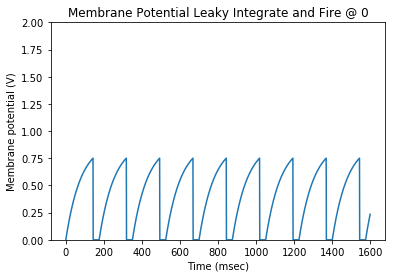

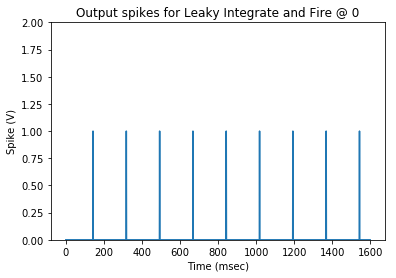

In [144]:
plot_membrane_potential(neuron0.time, neuron0.Vm, 'Membrane Potential {}'.format(neuron0.type), neuron_id = "0")
plot_spikes(neuron0.time, neuron0.spikes, 'Output spikes for {}'.format(neuron0.type), neuron_id = "0")

In [26]:
neuron2 = Neuron()

Neuron(): Created Leaky Integrate and Fire neuron starting at time 0


In [27]:
#neuron2_time = np.zeros(len(neuron_time))
#print (neuron2_time.shape)
#neuron2_Vm = np.zeros(len(neuron_Vm))
#print (neuron2_Vm.shape)
#neuron2_output = np.zeros(len(neuron_output))
#print (neuron2_output.shape)

In [145]:
neuron2_input = neurons[0][0].spikes
#print (neuron2_input.shape)
#neuron2_time = np.zeros(len(neuron_time))
#neuron2_Vm = np.zeros(len(neuron_Vm))
#neuron2_output = np.zeros(len(neuron_output))

In [147]:
neurons[1][0].spike_generator(neuron2_input)   #[time_step], duration=0.25)
#neuron2_time = np.append(neuron2_time,t)
#neuron2_Vm = np.append(neuron2_Vm,v)
#neuron2_output = np.append(neuron2_output, o)

spike_generator(): Running time period self.t=0, self.t+duration=1601
Neuron.spike_generator.initial_state(input=[ 0.  0.  0. ...,  0.  0.  0.], duration=1601, initial Vm=0.0, t=0)
Index 0
Index 1
spike_generator(): i=1, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.0, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 2
spike_generator(): i=2, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.0, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 3
spike_generator(): i=3, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.0, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 4
spike_generator(): i=4, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.0, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 5
spike_generator(): i=5, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.0, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 6
spike_generator(): i=6, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.0, neuron_input=0.0, self.Rm=1,

spike_generator(): i=617, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.0030253826375048237, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 618
spike_generator(): i=618, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.0029875653545360136, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 619
spike_generator(): i=619, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.0029502207876043133, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 620
spike_generator(): i=620, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.0029133430277592594, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 621
spike_generator(): i=621, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.0028769262399122686, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 622
spike_generator(): i=622, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.0028409646619133653, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 623
spike_generator(): i=623, t=

spike_generator(): i=1275, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.005138197155353098, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 1276
spike_generator(): i=1276, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.005073969690911184, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 1277
spike_generator(): i=1277, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.005010545069774794, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 1278
spike_generator(): i=1278, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.004947913256402609, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 1279
spike_generator(): i=1279, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.004886064340697577, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 1280
spike_generator(): i=1280, t=[   0    1    2 ..., 1597 1598 1599], Vm[i]=0.004824988536438857, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 1281
spike_generator(): i=1

In [148]:
start_time = 0
end_time = len(neuron_time)
print(start_time,end_time)

0 1601


In [31]:
print (neuron[0][2_time.shape)
print (neuron2_time)

(1601,)
[   0    1    2 ..., 1598 1599 1600]


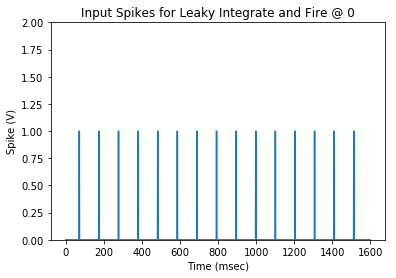

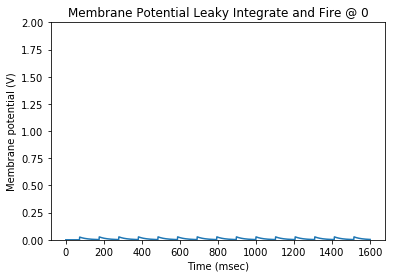

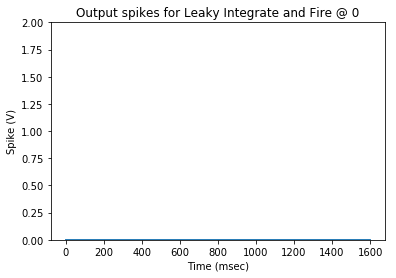

In [32]:
plot_spikes(neuron_time[start_time:end_time], neuron_output[start_time:end_time], 
            'Input Spikes for {}'.format(neuron2.type), neuron_id = "0")
plot_membrane_potential(neuron2_time[start_time:end_time], neuron2_Vm[start_time:end_time], 
            'Membrane Potential {}'.format(neuron2.type), neuron_id = "0")
plot_spikes(neuron2_time[start_time:end_time], neuron2_output[start_time:end_time], 
            'Output spikes for {}'.format(neuron2.type), neuron_id = "0")